In [1]:
%matplotlib inline
import numpy as np
from numpy.random import uniform
import igraph 
from time import time
from numpy.linalg import norm
import mpl_toolkits.mplot3d as a3
import matplotlib.pyplot as plt

In [2]:
def sort_vertices(v, d):
    if d[0] * d[1] < 0 and d[0] * d[2] < 0:
        return v, d
    if d[1] * d[0] < 0 and d[1] * d[2] < 0:
        return [v[1], v[0], v[2]], [d[1], d[0], d[2]]
    return [v[2], v[0], v[1]], [d[2], d[0], d[1]]

def collision_line(u0, u1, v0, v1):
    mu = (u1[1] - u0[1]) / (u1[0] - u0[0])
    iu = u0[1] - mu * u0[0]
    mv = (v1[1] - v0[1]) / (v1[0] - v0[0])
    iv = v0[1] - mv * v0[0]
    if abs(mu - mv) < 1.0e-6:
        return abs(iu - iv) < 1.0e-6
    x = (iu - iv) / (mv - mu)
    if (x > min(u0[0], u1[0]) and 
        x < max(u0[0], u1[0]) and 
        x > min(v0[0], v1[0]) and 
        x < max(v0[0], v1[0]) ):
        return True
    return False

def collision_face_coplanar(u, v):
    for i,j in [(0,1), (0,2), (1,2)]:
        for k,l in [(0,1), (0,2), (1,2)]:
            if collision_line(u[i], u[j], v[k], v[l]):
                return True
    return False


def collision_face(u, v):    
    Nv = np.cross(v[1] - v[0], v[2]-v[0])
    d2 = - np.dot(Nv, v[0])
    du = np.array([np.dot(Nv, x) + d2 for x in u])
    if np.all(du > 0) or np.all(du < 0):
        return False
    
    Nu = np.cross(u[1] - u[0], u[2]-u[0])
    d1 = - np.dot(Nu, u[0])
    dv = np.array([np.dot(Nu, x) + d1 for x in v])
    if np.all(dv > 0) or np.all(dv < 0):
        return False
    
    if np.all(du == 0):
        return collision_coplanar()
    
    D = np.cross(Nu, Nv)
    u, du = sort_vertices(u, du)
    v, dv = sort_vertices(v, dv)
    
    pu = [np.dot(D, x) for x in u]
    pv = [np.dot(D, x) for x in v]
    tu = [pu[i] + (pu[0] - pu[i])*du[i]/(du[i] - du[0]) for i in (1,2)]
    tv = [pv[i] + (pv[0] - pv[i])*dv[i]/(dv[i] - dv[0]) for i in (1,2)]
    
    if (tu[1] - tv[0]) * (tu[1] - tv[1]) < 0:
        return True
    if (tu[0] - tv[0]) * (tu[0] - tv[1]) < 0:
        return True
    if (tv[1] - tu[0]) * (tv[1] - tu[1]) < 0:
        return True
    if (tv[0] - tu[0]) * (tv[0] - tu[1]) < 0:
        return True
    return False

In [3]:
class Tet():
    radius = np.sqrt(3./8.)
    inner_radius = np.sqrt(1./24.)
    center_verts = [
            np.array([ 1/2.,     0, -1./np.sqrt(8)]),
            np.array([-1/2.,     0, -1./np.sqrt(8)]),
            np.array([    0,  1/2.,  1./np.sqrt(8)]),
            np.array([    0, -1/2.,  1./np.sqrt(8)])]
    
    def __init__(self, center, theta, phi, psi):
        rotation = np.array([
            [np.cos(phi), -np.cos(psi)*np.sin(phi), np.sin(phi)*np.sin(psi)],
            [np.cos(theta)*np.sin(phi), np.cos(theta)*np.cos(phi)*np.cos(psi) - np.sin(theta)*np.sin(psi), -np.cos(psi)*np.sin(theta) - np.cos(theta)*np.cos(phi)*np.sin(psi)],
            [np.sin(theta)*np.sin(phi), np.cos(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi)*np.sin(theta), np.cos(theta)*np.cos(psi)-np.cos(phi)*np.sin(theta)*np.sin(psi)]
            ])
        self.center = np.array(center)
        self.theta = theta
        self.phi = phi
        self.psi = psi
        self.verts = [np.dot(rotation, x) + self.center for x in self.center_verts]
        return
    
    def collision(self, other):
        dist = np.sum(np.square(self.center - other.center))
        if dist < np.square(2*self.inner_radius):
            return True
        if dist > np.square(2*self.radius):
            return False
        for i,j,k in [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]:
            for x,y,z in [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]:
                if collision_face([ self.verts[i],  self.verts[j],  self.verts[k]], 
                                  [other.verts[x], other.verts[y], other.verts[z]]):
                    return True
        return False
    
    def get_symetry_1d(self, v1):
        res = []
        if norm(v1) - np.dot(self.center, v1) / norm(v1) < 2*self.radius:
            res.append(Tet(self.center - v1, self.theta, self.phi, self.psi))
        if np.dot(self.center, v1) / norm(v1) < 2*self.radius:
            res.append(Tet(self.center + v1, self.theta, self.phi, self.psi))    
        return res
    
    def get_symetry(self, v1, v2, v3):
        syms = [self,] + self.get_symetry_1d(v1)
        for s in syms.copy():
            syms += s.get_symetry_1d(v2)
        for s in syms.copy():
            syms += s.get_symetry_1d(v3)
        return syms

In [4]:
t1 = Tet((0.5,0,0), 0, 0, .00)
t2 = Tet((0  ,0,0), 0, 0, .05)
t1.collision(t2)

True

In [5]:
def greedy1(adj):
    while np.sum(adj) > 0:
        max_row = np.argmax(np.sum(adj, axis=1))
        adj = np.delete(adj, max_row, 0)
        adj = np.delete(adj, max_row, 1)
    return adj.shape[0]

def greedy2(adj):
    while np.sum(adj) > 0:
        min_row = np.argmin(np.sum(adj, axis=1))
        to_remove = np.nonzero(adj[min_row,:])
        adj = np.delete(adj, to_remove, 0)
        adj = np.delete(adj, to_remove, 1)
    return adj.shape[0]

In [6]:
N = 20
L = 1
vx = np.array([L,0,0])
vy = np.array([0,L,0])
vz = np.array([0,0,L])
tets = []
t0 = time()
for i in range(N):
    center = uniform(0, L, 3)
    theta = uniform(0, 2*np.pi)
    phi = uniform(0, 2*np.pi)
    psi = uniform(9, 2*np.pi)
    tets.append(Tet(center, theta, phi, psi))
print(">> Took {:7.4f}s to make Tets".format(time()-t0))

t0 = time()
g = igraph.Graph()
g.add_vertices(N)
for i in range(N):
    for j in range(i+1,N):
        for s in tets[j].get_symetry(vx, vy, vz):
            if tets[i].collision(s):
                g.add_edge(i,j)
                continue
adjacency = np.array(g.get_adjacency()._get_data())
print(">> Took {:7.4f}s to make graph".format(time()-t0))

col = np.sum(adjacency)/2
print(col, N*N/col /(6*np.sqrt(2)) / L**3)

t0 = time()
num_packed = greedy1(adjacency)
packing_ratio = num_packed / (6*np.sqrt(2)) / L**3
print(L, num_packed, packing_ratio)
print(">> Took {:7.4f}s for greedy algorithm".format(time()-t0))

t0 = time()
num_packed = g.independence_number()
packing_ratio = num_packed / (6*np.sqrt(2)) / L**3
print(L, num_packed, packing_ratio)
print(">> Took {:7.4f}s to compute independence number".format(time()-t0))

>> Took  0.0018s to make Tets
>> Took  2.0156s to make graph
340.0 0.138648388468
1 2 0.235702260396
>> Took  0.0013s for greedy algorithm


In [7]:
t0 = time()
largest_independent_set = g.largest_independent_vertex_sets()[0]
print(largest_independent_set)
print(">> Took {:7.4f}s to return independent set".format(time()-t0))

(0, 18)
>> Took  0.0004s to return independent set


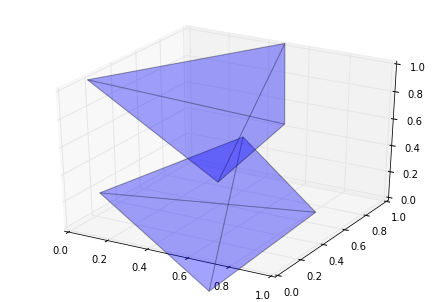

In [8]:
import scipy as sp
ax = a3.Axes3D(plt.figure(10))
for i in largest_independent_set:
    for x,y,z in [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]:
        verts = [tuple(tets[i].verts[x]), tuple(tets[i].verts[y]), tuple(tets[i].verts[z])]
        tri = a3.art3d.Poly3DCollection([verts], alpha=0.2)
        tri.set_edgecolor('k')
        ax.add_collection3d(tri)
ax.set_xlim(0,L)
ax.set_ylim(0,L)
ax.set_zlim(0,L)
plt.show()